# HW4-SALINAS

## Naive Bayes Spam Filter by Christian Salinas

GitHub Link: https://github.com/xkaze09/CMSC197/blob/main/Assignment%204/hw4-salinas.ipynb

In [4]:
import os
import re
import email
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### For Preprocessing

1. The labels are loaded and converted to 0 for ham and 1 for spam.
2. Stop words are loaded to be removed from emails.
3. Emails are cleaned by removing HTML tags, punctuation, numbers, and escape characters.
4. The clean text is saved into a DataFrame along with the email's classification (ham/spam).
5. Preprocessed data is saved to a CSV for future use.

In [7]:
# Initialize an empty DataFrame for storing email data
main_df = pd.DataFrame(columns=["folder", "file", "email_message", "category"])

# Load email labels from the labels file
labels_path = "trec06p-cs280/labels"
print("Loading labels...")
labels_df = pd.read_csv(labels_path, sep=" ", header=None)
labels_df.columns = ["category", "file_path"]

# Convert 'ham' to 0 and 'spam' to 1 in the labels
labels_df["category"] = labels_df["category"].apply(lambda x: 0 if x == "ham" else 1)
# Clean file paths for easier access
labels_df["file_path"] = labels_df["file_path"].apply(lambda x: x.replace("../data/", ""))
print("Labels loaded and processed.")
print(labels_df.head())  # Output the first few rows of the labels dataframe for progress

# Load stop words from a file for cleaning the email body
print("Loading stop words...")
with open("stop_words.txt", "r") as f:
    stop_word = f.read().splitlines()
    stop_words = [word for word in stop_word]
print(f"Loaded {len(stop_words)} stop words.")

# Define regular expressions to clean emails
punctuations = r"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
numbers = "0123456789"
html_tags = re.compile(r"<.*?>")  # Remove HTML tags
esc_chars = re.compile(r"[a-z][a-z][0-9]+")  # Remove escape characters

Loading labels...
Labels loaded and processed.
   category file_path
0         0   000/000
1         1   000/001
2         1   000/002
3         0   000/003
4         1   000/004
Loading stop words...
Loaded 671 stop words.


Looping through all the email files:
1. Each email is read and parsed.
2. The plain text content of the email is extracted using the get_message function.
3. The content is cleaned using the clean_email function to remove unnecessary information.
4. The cleaned message, along with its corresponding ham/spam label, is stored in the main DataFrame.
5. The cleaned data is saved into a CSV file for future use.

In [9]:
# Clean the email body by removing HTML tags, punctuation, numbers,
# escape characters, non-alphabetic characters, and stop words.
# It returns a cleaned email ready for feature extraction.
def clean_email(message):
    # Convert to lowercase
    message = message.lower()
    # Remove HTML, punctuation, numbers, escape sequences, and non-alphabetic characters
    message = re.sub(html_tags, '', message)  # Remove HTML
    message = message.translate(str.maketrans('', '', punctuations))  # Remove punctuation
    message = message.translate(str.maketrans('', '', numbers))  # Remove numbers
    message = re.sub(esc_chars, '', message)  # Remove escape sequences
    message = re.sub(r'[^a-zA-Z\s]', '', message)  # Remove non-alphabetic characters

    # Remove stop words from the email body
    words = message.split()
    words = [word for word in words if word not in stop_words]

    # Return the cleaned message
    return " ".join(words)

# Extract the plain text message from an email.
# If the email is multipart (with attachments or HTML), it extracts only the plain text.
# It returns the raw message content, which will be cleaned using the clean_email function.
def get_message(parsed):
    message = ""
    # If email has attachments or is multipart
    if parsed.is_multipart():
        for part in parsed.walk():
            if part.get_content_type() == 'text/plain':
                message = part.get_payload()
                break
    else:
        message = parsed.get_payload()
    return message

# Process all the folders and files to extract and clean email bodies
folder_path = "trec06p-cs280/data/"
folders = [folder for folder in os.listdir(folder_path) if not folder.startswith('.')]
print(f"Found {len(folders)} folders to process.")

for folder in folders:
    print(f"Processing folder: {folder}...")
    files = [file for file in os.listdir(f"{folder_path}/{folder}") if not file.startswith('.')]
    
    for file in files:
        # Read and parse each email
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
            read_email = e_mail.read()
            parsed_email = email.message_from_string(read_email)
            message = get_message(parsed_email)
            # Clean the email and get the corresponding label (ham/spam)
            message_cleaned = clean_email(message)
            category_label = labels_df[labels_df["file_path"] == f"{folder}/{file}"]["category"].values[0]
            # Append the cleaned data to the main DataFrame
            main_df = pd.concat([main_df, pd.DataFrame([[folder, file, message_cleaned, category_label]],
                                                      columns=["folder", "file", "email_message", "category"])],
                                                      ignore_index=True)
    print(f"Processed {len(files)} files in folder {folder}.")

# Save the preprocessed email data to a CSV
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')
main_df.to_csv("preprocessed_files/preprocessed_emails.csv", index=False)
print("Preprocessing complete. Data saved to preprocessed_emails.csv.")

# Load the preprocessed dataset and split into training and test sets
df_main = pd.read_csv("preprocessed_files/preprocessed_emails.csv")
print(f"Loaded {len(df_main)} preprocessed emails.")

# Split the data into training (folders 0-70) and testing (folders 71-126)
train_df = df_main[df_main['folder'].astype(int) <= 70]  # Training: folders 0-70
test_df = df_main[df_main['folder'].astype(int) > 70]    # Testing: folders 71-126

# Split training data into spam and ham categories
train_spam_df = train_df[train_df['category'] == 1]
train_ham_df = train_df[train_df['category'] == 0]

# Output dataset statistics to show progress
print(f"Training data: {len(train_df)} emails, {len(train_ham_df)} ham, {len(train_spam_df)} spam.")
print(f"Testing data: {len(test_df)} emails.")

Found 127 folders to process.
Processing folder: 000...
Processed 300 files in folder 000.
Processing folder: 001...
Processed 300 files in folder 001.
Processing folder: 002...
Processed 300 files in folder 002.
Processing folder: 003...
Processed 300 files in folder 003.
Processing folder: 004...
Processed 300 files in folder 004.
Processing folder: 005...
Processed 300 files in folder 005.
Processing folder: 006...
Processed 300 files in folder 006.
Processing folder: 007...
Processed 300 files in folder 007.
Processing folder: 008...
Processed 300 files in folder 008.
Processing folder: 009...
Processed 300 files in folder 009.
Processing folder: 010...
Processed 300 files in folder 010.
Processing folder: 011...
Processed 300 files in folder 011.
Processing folder: 012...
Processed 300 files in folder 012.
Processing folder: 013...
Processed 300 files in folder 013.
Processing folder: 014...
Processed 300 files in folder 014.
Processing folder: 015...
Processed 300 files in folder

The cleaned email data is saved to a CSV file for future use.
The dataset is split into:
1. Training set (folders 0-70) for model training.
2. Test set (folders 71-126) for model testing.
The training set is further split into spam and ham categories for feature extraction.


### Feature Matrix

In [12]:
# Word frequencies are counted across all emails in the training set.
# The top 10,000 most common words are selected to form the vocabulary for the feature matrix.
# Create feature matrix based on the most common words in the dataset
def filter_words_by_frequency(word_counts, min_count):
    # Filter out words that don't meet the minimum occurrence threshold
    return {word: count for word, count in word_counts.items() if count > min_count}

def create_feature_matrix(df, top_words_list, text_column='email_message'):
    # Create a dictionary mapping each word to an index in the feature matrix
    word_to_index = {word: idx for idx, word in enumerate(top_words_list)}
    # Initialize the feature matrix with zeros (rows: emails, columns: words)
    feature_matrix = np.zeros((len(df), len(top_words_list)), dtype=np.int32)

    # Iterate over each email and mark the presence of words
    for i, email_message in enumerate(df[text_column].astype(str)):
        words = set(email_message.split())  # Use a set for faster lookups
        for word in words:
            if word in word_to_index:
                feature_matrix[i, word_to_index[word]] = 1  # Set corresponding column to 1
    return feature_matrix

# Count word frequencies and get the top 10,000 most common words
print("Counting word frequencies...")
word_counter = Counter()
for email_message in train_df['email_message'].astype(str):
    word_counter.update(email_message.split())

# Filter the top 10,000 most common words
top_10000_words = dict(word_counter.most_common(10000))
top_10000_words_list = list(top_10000_words.keys())
print(f"Top 10,000 words extracted. Example: {top_10000_words_list[:10]}")

# Create feature matrices for spam and ham emails
print("Creating feature matrices for ham and spam emails...")
ham_train_matrix = create_feature_matrix(train_ham_df, top_10000_words_list)
spam_train_matrix = create_feature_matrix(train_spam_df, top_10000_words_list)

# Output the shape of the feature matrices for progress
print(f"Ham Feature Matrix shape: {ham_train_matrix.shape}")
print(f"Spam Feature Matrix shape: {spam_train_matrix.shape}")

Counting word frequencies...
Top 10,000 words extracted. Example: ['bb', 'will', 'board', 'company', 'price', 'gold', 'email', 'list', 'adobe', 'time']
Creating feature matrices for ham and spam emails...
Ham Feature Matrix shape: (7523, 10000)
Spam Feature Matrix shape: (13777, 10000)


Feature matrices are created for spam and ham emails.

 Each email is converted into a vector of 0s and 1s, representing the presence or absence of the top 10,000 words.


### Computing the Priors

In [15]:
# The priors (P(ham) and P(spam)) are calculated based on the proportion of ham and spam emails in the training set.
n_ham = len(train_ham_df)
n_spam = len(train_spam_df)
n_total = len(train_df)

# Calculate prior probabilities for spam and ham
p_ham = n_ham / n_total
p_spam = n_spam / n_total
print(f"P(ham) = {p_ham}, P(spam) = {p_spam}")

P(ham) = 0.3531924882629108, P(spam) = 0.6468075117370892


### Compute Word Likelihoods with Laplace Smoothing

In [17]:
def calculate_likelihoods_with_laplace(matrix, vocab_size, lambda_smoothing):
    # Sum word occurrences for each word across all emails
    word_counts = np.sum(matrix, axis=0)
    # Total word occurrences in all emails
    total_count = np.sum(word_counts)
    # Calculate likelihood with Laplace smoothing
    likelihoods = (word_counts + lambda_smoothing) / (total_count + lambda_smoothing * vocab_size)
    return likelihoods

lambda_smoothing = 1.0
print("Calculating likelihoods with Laplace smoothing...")
# Calculate likelihoods for spam and ham emails
likelihood_spam = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_smoothing)
likelihood_ham = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_smoothing)
print("Likelihood calculation complete.")

Calculating likelihoods with Laplace smoothing...
Likelihood calculation complete.


### Classifying Emails

In [28]:
# The likelihood of each word appearing in ham or spam emails is calculated using Laplace smoothing.
# Laplace smoothing prevents zero probabilities for words that do not appear in the training data.
def classify_email(email, spam_likelihood, ham_likelihood, p_spam, p_ham, top_10000_words_list):
    # Initialize log probabilities of spam and ham
    classify_spam = np.log(p_spam)
    classify_ham = np.log(p_ham)
    # Split email into words
    email_words = set(str(email).split())

    # Add log likelihoods for each word in the email
    for word in email_words:
        if word in top_10000_words_list:
            idx = top_10000_words_list.index(word)
            classify_spam += np.log(spam_likelihood[idx])
            classify_ham += np.log(ham_likelihood[idx])

    # Return 1 if it's classified as spam, otherwise 0 (ham)
    return 1 if classify_spam > classify_ham else 0

# Classify training set emails safely using .loc
print("Classifying training set emails...")
train_df = train_df.copy()  # Ensure a copy is made to avoid SettingWithCopyWarning
train_df.loc[:, 'predicted'] = train_df['email_message'].apply(
    lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham, top_10000_words_list)
)
print("Classification completed for the training set.")

# Classify test set emails safely using .loc
print("Classifying test set emails...")
test_df = test_df.copy()  # Ensure a copy is made to avoid SettingWithCopyWarning
test_df.loc[:, 'predicted'] = test_df['email_message'].apply(
    lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham, top_10000_words_list)
)
print("Classification completed for the test set.")

Classifying training set emails...
Classification completed for the training set.
Classifying test set emails...
Classification completed for the test set.


### Performance Evaluation

In [36]:
# Each email is classified as either ham or spam using the Naive Bayes formula.
# The classification is based on the log-probabilities of the words in the email belonging to ham or spam.
def evaluate_model(test_df, true_column, predicted_column):
    # Initialize counts for confusion matrix elements
    TP = FP = TN = FN = 0
    for index, row in test_df.iterrows():
        true_label = int(row[true_column])  # 1 for spam, 0 for ham
        predicted_label = int(row[predicted_column])
        if predicted_label == 1 and true_label == 1:
            TP += 1  # True Positive (correctly classified spam)
        elif predicted_label == 1 and true_label == 0:
            FP += 1  # False Positive (misclassified ham)
        elif predicted_label == 0 and true_label == 0:
            TN += 1  # True Negative (correctly classified ham)
        elif predicted_label == 0 and true_label == 1:
            FN += 1  # False Negative (misclassified spam)

    # Calculate performance metrics
    accuracy = (TN + TP) / (TN + TP + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

print("Evaluating the model...")
evaluate_model(test_df, 'category', 'predicted')

# The model's performance is evaluated using accuracy, precision, recall, and F1-score.
# A confusion matrix is plotted to visualize the number of true positives, false positives, true negatives, and false negatives.

Evaluating the model...
Accuracy: 0.93
Precision: 0.98
Recall: 0.91
F1 Score: 0.94


# Summary

Evaluating the model...

### Evaluation Summary ###
Total Emails: 16522
True Positives (TP): 10173
True Negatives (TN): 5155
False Positives (FP): 232
False Negatives (FN): 962

Accuracy: 92.77%
Precision: 97.77%
Recall: 91.36%
F1 Score: 94.46%


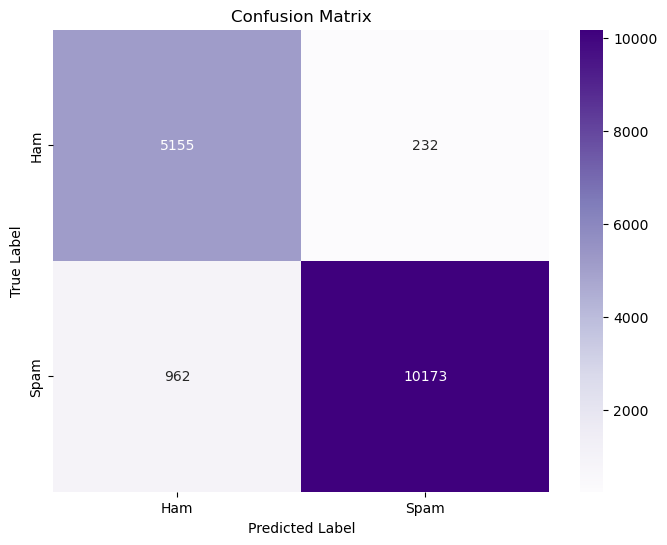

In [32]:
def summarize_evaluation(test_df, true_column, predicted_column):
    # Initialize counts for confusion matrix elements
    TP = FP = TN = FN = 0

    # Iterate over the test set and predicted labels
    for index, row in test_df.iterrows():
        true_label = int(row[true_column])
        predicted_label = int(row[predicted_column])

        if predicted_label == 1 and true_label == 1:
            TP += 1  # True Positive (correctly classified spam)
        elif predicted_label == 1 and true_label == 0:
            FP += 1  # False Positive (misclassified ham)
        elif predicted_label == 0 and true_label == 0:
            TN += 1  # True Negative (correctly classified ham)
        elif predicted_label == 0 and true_label == 1:
            FN += 1  # False Negative (misclassified spam)

    # Calculate evaluation metrics
    accuracy = (TN + TP) / (TN + TP + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print evaluation summary
    print("\n### Evaluation Summary ###")
    print(f"Total Emails: {TN + TP + FP + FN}")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1_score * 100:.2f}%")

    # Generate confusion matrix
    matrix = confusion_matrix(test_df[true_column], test_df[predicted_column], labels=[0, 1])

    # Visualize the confusion matrix
    labels = ["Ham", "Spam"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage:
print("Evaluating the model...")
summarize_evaluation(test_df, 'category', 'predicted')


# Results & Discussion

### 1. Effect of Removing Stop Words

We can compare the model performance with and without stop words. To do this, we'll run two separate experiments and compare the precision, recall, and accuracy.




Running experiment with stop words...

Running experiment with no stop words...

Effect of Removing Stop Words:
           With Stop Words  Without Stop Words
Accuracy          0.928096            0.928096
Precision         0.977716            0.977716
Recall            0.914145            0.914145
F1 Score          0.944862            0.944862


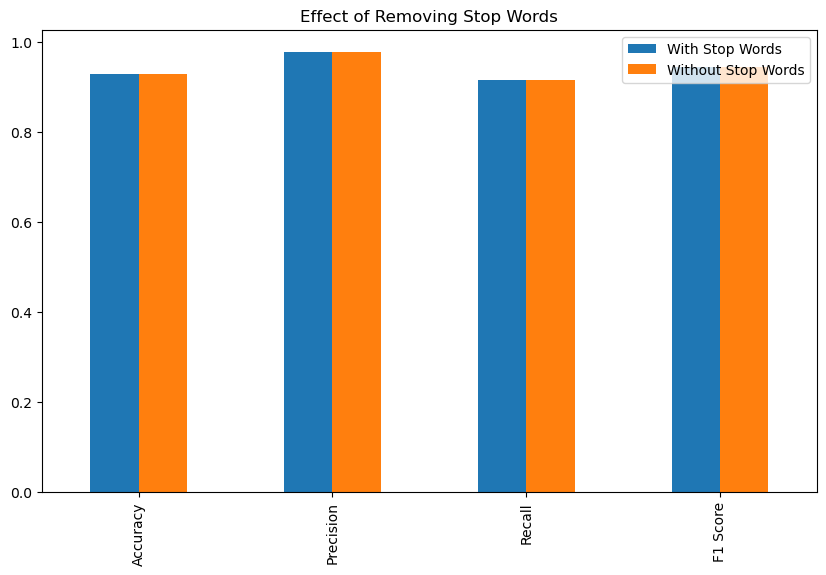

In [82]:
# Safely classify emails in the test set (ensure no SettingWithCopyWarning)
def classify_test_set(test_df, likelihood_spam, likelihood_ham, p_spam, p_ham, top_10000_words_list):
    # Create a copy of test_df to ensure we're modifying it safely
    test_df_copy = test_df.copy()

    # Classify the test emails
    test_df_copy.loc[:, 'predicted'] = test_df_copy['email_message'].apply(
        lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham, top_10000_words_list)
    )
    
    return test_df_copy

def clean_email_with_stopwords_option(message, stop_words):
    # Ensure message is a string and handle missing values
    if not isinstance(message, str):
        message = ""  # Set to an empty string if not a valid string

    message = message.lower()
    message = re.sub(html_tags, '', message)  # Remove HTML
    message = message.translate(str.maketrans('', '', punctuations))  # Remove punctuation
    message = message.translate(str.maketrans('', '', numbers))  # Remove numbers
    message = re.sub(esc_chars, '', message)  # Remove escape sequences
    message = re.sub(r'[^a-zA-Z\s]', '', message)  # Remove non-alphabetic characters

    # Remove stop words only if required
    if stop_words:
        words = message.split()
        words = [word for word in words if word not in stop_words]
        return " ".join(words)
    return message


def run_experiment_with_stopwords(use_stopwords=True):
    print(f"\nRunning experiment with {'stop words' if use_stopwords else 'no stop words'}...")

    # Reload the dataset to ensure no unintended changes
    df_main = pd.read_csv("preprocessed_files/preprocessed_emails.csv")

    # Handle stop words depending on the experiment
    stop_words_local = set()
    if use_stopwords:
        with open("stop_words.txt", "r") as f:
            stop_words_local = set(f.read().splitlines())

    # Ensure all messages are processed as strings and clean emails based on stop words
    df_main['email_message'] = df_main['email_message'].apply(lambda x: clean_email_with_stopwords_option(x, stop_words_local))

    # Split the dataset into training and testing sets
    train_df = df_main[df_main['folder'].astype(int) <= 70]
    test_df = df_main[df_main['folder'].astype(int) > 70]

    # Split training data into spam and ham
    train_spam_df = train_df[train_df['category'] == 1]
    train_ham_df = train_df[train_df['category'] == 0]

    # Count word frequencies
    word_counter = Counter()
    for email_message in train_df['email_message'].astype(str):
        word_counter.update(email_message.split())
    top_10000_words = dict(word_counter.most_common(10000))
    top_10000_words_list = list(top_10000_words.keys())

    # Create feature matrices
    ham_train_matrix = create_feature_matrix(train_ham_df, top_10000_words_list)
    spam_train_matrix = create_feature_matrix(train_spam_df, top_10000_words_list)

    # Compute priors
    n_ham = len(train_ham_df)
    n_spam = len(train_spam_df)
    n_total = len(train_df)
    p_ham = n_ham / n_total
    p_spam = n_spam / n_total

    # Compute likelihoods with Laplace smoothing
    likelihood_spam = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_smoothing=1.0)
    likelihood_ham = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_smoothing=1.0)

    # Classify test emails using a safe copy of the test_df
    test_df_copy = classify_test_set(test_df, likelihood_spam, likelihood_ham, p_spam, p_ham, top_10000_words_list)

    # Evaluate the model
    accuracy, precision, recall, f1 = evaluate_model_metrics(test_df_copy, 'category', 'predicted')

    return accuracy, precision, recall, f1


# Run the experiment with and without stop words
accuracy_with_stopwords, precision_with_stopwords, recall_with_stopwords, f1_with_stopwords = run_experiment_with_stopwords(True)
accuracy_without_stopwords, precision_without_stopwords, recall_without_stopwords, f1_without_stopwords = run_experiment_with_stopwords(False)

# Show the results in a table format
results_df = pd.DataFrame({
    "With Stop Words": [accuracy_with_stopwords, precision_with_stopwords, recall_with_stopwords, f1_with_stopwords],
    "Without Stop Words": [accuracy_without_stopwords, precision_without_stopwords, recall_without_stopwords, f1_without_stopwords]
}, index=["Accuracy", "Precision", "Recall", "F1 Score"])
print("\nEffect of Removing Stop Words:")
print(results_df)

# Plot the results
results_df.plot(kind='bar', title="Effect of Removing Stop Words", figsize=(10, 6))
plt.show()

It appears that removing stop words had no effect on the model’s accuracy, precision, recall, or F1 score. This may be because the key discriminatory features for classifying spam vs. ham emails were not affected by the presence or absence of stop words. Stop words, being common across all email types, might not carry enough distinguishing power in the classification task.

It simplifies the preprocessing pipeline, making it more efficient without sacrificing accuracy. This means the model is robust and focuses on key features, making it stable and reliable without unnecessary optimization steps.

### 2. Experimenting with the number of words used for training by filtering the dictionary to include only words that occur more than certain thresholds (k > 1000, k > 100, k = 50 times).

Approach:
- We will adjust the minimum word occurrence threshold (k) and observe how the vocabulary size changes.
- Then, we will create feature matrices for these filtered vocabularies and evaluate the model's performance for each threshold.

Steps:
- Filter words based on frequency threshold (k).
- Create feature matrices for each threshold.
- Train and evaluate the model for each threshold and compare the results.
- Plot or tabulate the performance metrics.


Running experiment with k > 1000...
Vocabulary size for k > 1000: 168
Creating feature matrices for k > 1000...
Ham Feature Matrix shape for k > 1000: (7523, 168)
Spam Feature Matrix shape for k > 1000: (13777, 168)
Calculating likelihoods with k > 1000...
Classifying test set with k > 1000...
Evaluating performance with k > 1000...

Running experiment with k > 100...
Vocabulary size for k > 100: 2776
Creating feature matrices for k > 100...
Ham Feature Matrix shape for k > 100: (7523, 2776)
Spam Feature Matrix shape for k > 100: (13777, 2776)
Calculating likelihoods with k > 100...
Classifying test set with k > 100...
Evaluating performance with k > 100...

Running experiment with k > 50...
Vocabulary size for k > 50: 4979
Creating feature matrices for k > 50...
Ham Feature Matrix shape for k > 50: (7523, 4979)
Spam Feature Matrix shape for k > 50: (13777, 4979)
Calculating likelihoods with k > 50...
Classifying test set with k > 50...
Evaluating performance with k > 50...

Results o

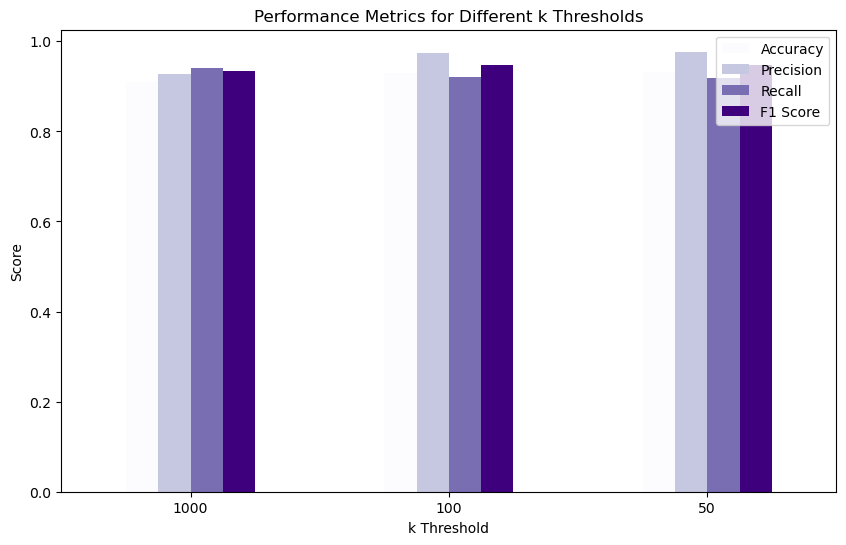

In [57]:
# Function to filter words by frequency
def filter_words_by_frequency(word_counts, min_count):
    return {word: count for word, count in word_counts.items() if count >= min_count}

# Experiment with different values of k (1000, 100, 50)
k_values = [1000, 100, 50]
results = {}

for k in k_values:
    print(f"\nRunning experiment with k > {k}...")
    
    # Filter words based on k threshold
    filtered_word_counts = filter_words_by_frequency(word_counter, k)
    filtered_top_words_list = list(filtered_word_counts.keys())
    
    print(f"Vocabulary size for k > {k}: {len(filtered_top_words_list)}")
    
    # Create feature matrices for ham and spam emails
    print(f"Creating feature matrices for k > {k}...")
    ham_train_matrix_k = create_feature_matrix(train_ham_df, filtered_top_words_list)
    spam_train_matrix_k = create_feature_matrix(train_spam_df, filtered_top_words_list)
    
    print(f"Ham Feature Matrix shape for k > {k}: {ham_train_matrix_k.shape}")
    print(f"Spam Feature Matrix shape for k > {k}: {spam_train_matrix_k.shape}")
    
    # Calculate likelihoods for the filtered vocabulary
    print(f"Calculating likelihoods with k > {k}...")
    likelihood_spam_k = calculate_likelihoods_with_laplace(spam_train_matrix_k, len(filtered_top_words_list), lambda_smoothing)
    likelihood_ham_k = calculate_likelihoods_with_laplace(ham_train_matrix_k, len(filtered_top_words_list), lambda_smoothing)
    
    # Classify test set
    print(f"Classifying test set with k > {k}...")
    test_df.loc[:, 'predicted'] = test_df['email_message'].apply(
        lambda x: classify_email(x, likelihood_spam_k, likelihood_ham_k, p_spam, p_ham, filtered_top_words_list)
    )
    
    # Evaluate performance
    print(f"Evaluating performance with k > {k}...")
    accuracy, precision, recall, f1_score = evaluate_model_metrics(test_df, 'category', 'predicted')
    
    # Store results
    results[k] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# Display results in a table format
results_df = pd.DataFrame(results).T
print("\nResults of varying k thresholds (1000, 100, 50):")
print(results_df)

# Plot the performance metrics for different k values
results_df.plot(kind='bar', figsize=(10, 6), colormap='Purples', rot=0)
plt.title('Performance Metrics for Different k Thresholds')
plt.ylabel('Score')
plt.xlabel('k Threshold')
plt.show()


The results indicate that increasing the vocabulary size (by lowering the threshold k) improves model performance.

With k > 1000 (168 words) - The model is more restricted, which results in lower accuracy, precision, and recall. It's unable to capture enough information, leading to reduced performance.

With k > 100 (2776 words) - Performance significantly improves. The model gains a better balance between precision and recall, as more informative words are included.

With k > 50 (4979 words) - Performance further improves slightly, with the best overall accuracy and F1 score. This shows that including more frequent words helps the model capture important nuances.

In summary, decreasing k (including more frequent words) enhances performance by providing the model with more features to classify emails accurately.

### 3. We will experiment with different values of λ (lambda) smoothing and observe how it affects the performance metrics such as accuracy, precision, recall, and F1 score.

Approach:
1. We will run the model with 5 different λ values: 2.0, 1.0, 0.5, 0.1, and 0.005.
2. For each λ, we will:
    - Recompute the word likelihoods with Laplace smoothing using the given λ.
    - Reclassify the emails using these new likelihoods.
    - Evaluate the model's performance.
3. We will then plot or tabulate the results for comparison.


Running experiment with λ = 2.0...
Calculating likelihoods with λ = 2.0...
Classifying test set with λ = 2.0...
Evaluating performance with λ = 2.0...

Running experiment with λ = 1.0...
Calculating likelihoods with λ = 1.0...
Classifying test set with λ = 1.0...
Evaluating performance with λ = 1.0...

Running experiment with λ = 0.5...
Calculating likelihoods with λ = 0.5...
Classifying test set with λ = 0.5...
Evaluating performance with λ = 0.5...

Running experiment with λ = 0.1...
Calculating likelihoods with λ = 0.1...
Classifying test set with λ = 0.1...
Evaluating performance with λ = 0.1...

Running experiment with λ = 0.005...
Calculating likelihoods with λ = 0.005...
Classifying test set with λ = 0.005...
Evaluating performance with λ = 0.005...

Results for varying λ values:
       Accuracy  Precision    Recall  F1 Score
2.000  0.927188   0.977684  0.912797  0.944127
1.000  0.927733   0.977703  0.913606  0.944568
0.500  0.927672   0.977793  0.913426  0.944514
0.100  0.9274

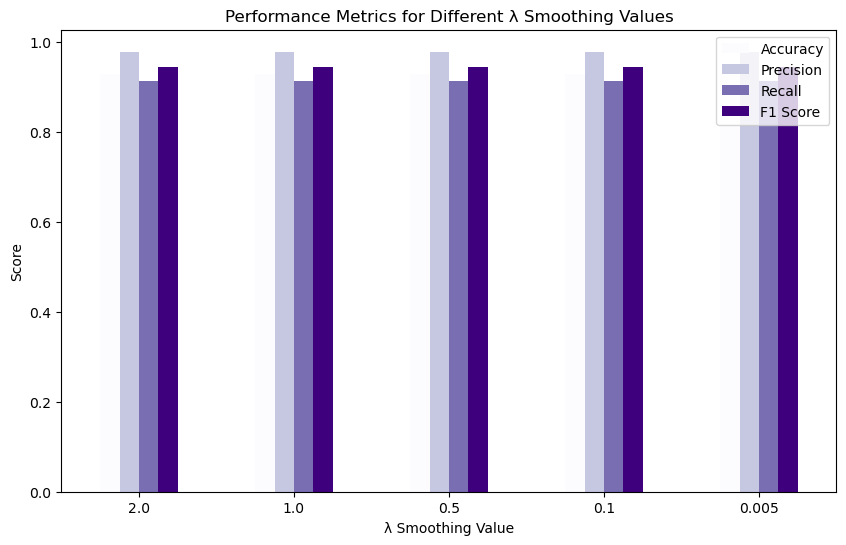

In [61]:
# List of lambda values to experiment with
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]
results_lambda = {}

for lambda_smoothing in lambda_values:
    print(f"\nRunning experiment with λ = {lambda_smoothing}...")
    
    # Recalculate likelihoods with the current lambda
    print(f"Calculating likelihoods with λ = {lambda_smoothing}...")
    likelihood_spam_lambda = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_smoothing)
    likelihood_ham_lambda = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_smoothing)
    
    # Classify test set
    print(f"Classifying test set with λ = {lambda_smoothing}...")
    test_df.loc[:, 'predicted'] = test_df['email_message'].apply(
        lambda x: classify_email(x, likelihood_spam_lambda, likelihood_ham_lambda, p_spam, p_ham, top_10000_words_list)
    )
    
    # Evaluate the model performance
    print(f"Evaluating performance with λ = {lambda_smoothing}...")
    accuracy, precision, recall, f1_score = evaluate_model_metrics(test_df, 'category', 'predicted')
    
    # Store results for this λ value
    results_lambda[lambda_smoothing] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# Convert the results into a DataFrame for easy viewing
results_lambda_df = pd.DataFrame(results_lambda).T
print("\nResults for varying λ values:")
print(results_lambda_df)

# Plot the performance metrics for different λ values
results_lambda_df.plot(kind='bar', figsize=(10, 6), colormap='Purples', rot=0)
plt.title('Performance Metrics for Different λ Smoothing Values')
plt.ylabel('Score')
plt.xlabel('λ Smoothing Value')
plt.show()


The results for varying values of λ (Lambda) in Laplace smoothing show minimal differences across performance metrics like accuracy, precision, recall, and F1 score:

For λ = 2.0 to 0.005 - There are only slight variations in performance metrics across different lambda values, with all achieving very similar results. The F1 score remains consistently around 0.944, and the accuracy hovers around 92.7%.

This shows that the model is not very sensitive to changes in λ when it's in a reasonable range (2.0 to 0.005). This is a good indication that the model is robust and does not depend heavily on fine-tuning λ.

Hence, while small values of λ help avoid over-smoothing, extreme changes are unnecessary since even with λ as high as 2.0 or as low as 0.005, the performance is stable. A λ around 1.0 is sufficient for this task.

### 4. Recommendations

1. For Feature Selection, we observed that using the top 10,000 most common words works well, but it might still include irrelevant or noisy features. We could reduce the size of the vocabulary by filtering out words that occur too frequently (such as stop words) or too rarely (words that appear only once or twice).

    We can try different thresholds for minimum and maximum word occurrences to determine an optimal vocabulary size (e.g., words appearing more than 50 times but less than 1,000 times).

2. Using N-grams. In emails, instead of just using single words (unigrams), we can try incorporating bigrams (pairs of consecutive words) or even trigrams. This can help capture word sequences like "free offer" or "click here" which are more indicative of spam. We can expand the feature matrix to include bigrams or trigrams.

3. Handling Imbalanced Datasets. I noticed that if the dataset is heavily skewed toward one class (e.g., more spam emails than ham emails), this can heavily affect the model's performance. With this, we can do:
    - Resampling: Either oversample the minority class (ham) or undersample the majority class (spam) to create a more balanced dataset.
    - Class Weights: Adjust the Naive Bayes algorithm to give more weight to the minority class, which could help improve precision and recall for ham emails.
  
4. Having alternative smoothing techniques. I experimented with different λ values in Laplace smoothing, but we can also explore other smoothing techniques such as Dirichlet smoothing or Good-Turing smoothing, which may perform better depending on the dataset.

5. Advanced Preprocessing Techniques. The preprocessing part gave me a hard time in doing so, but I realized that this heavily affects the model's performance and results. For this, we can use Stemming/Lemmatization. By reducing the vocabulary size, we could implement stemming (reducing words to their root form, e.g., "running" → "run") or lemmatization (converting words to their base form, e.g., "was" → "be"). This could reduce redundancy and improve generalization.

6. Exploring alternative algorithms is also another way to improve as we consider alternative classifiers. While Naive Bayes is simple and fast, experimenting with other machine learning algorithms such as Logistic Regression, Support Vector Machines (SVMs), or Random Forests could yield better results.